
# Shor (Scaffold)

- **Hadamard layer** 
- **QFT** 
- **Measurement** 

It is **not** a full implementation of Shor's algorithm (no modular exponentiation / controlled $U_a$).  


## Imports and Setup

In [3]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit_aer import AerSimulator


## Backend Selection (IBM if available, else Simulator)

In [7]:
token = os.environ.get("QUANTUM_TOKEN")
instance=os.environ.get("QUANTUM_INSTANCE")
service = QiskitRuntimeService(channel="ibm_cloud", token=token, instance=instance)
ibm_backend = service.backend("ibm_fez")
sim_backend = AerSimulator()


## Circuit Construction (Hadamards + QFT on first half)

In [6]:

def create_shors_scaffold(n: int, a: int, num_qubits: int) -> QuantumCircuit:
    """Create the pedagogical scaffold that mirrors your backend code:
    - A single register of `num_qubits`, with the first half acting as the 'phase' register
    - Apply Hadamards on the first half
    - Apply QFT on that first half (note: a working Shor would use the **inverse** QFT after the oracle)
    - Measure that first half

    Parameters
    ----------
    n : int
        The composite to factor (kept for parity with API; not used by this scaffold).
    a : int
        The base for modular exponentiation (not used here; used in post-processing).
    num_qubits : int
        Total number of qubits; the first half are considered the phase register.

    Returns
    -------
    QuantumCircuit
        The circuit with H + QFT + measure on the first half of the qubits.
    """
    if num_qubits % 2 != 0:
        raise ValueError("num_qubits must be even so it can be split into two halves.")
    half = num_qubits // 2

    qc = QuantumCircuit(num_qubits, half)

    # 1) Hadamards on the 'phase' half
    for i in range(half):
        qc.h(i)

    # 2) QFT on the same half (educational, *not* the working inverse QFT placement)
    qc.append(QFT(half, do_swaps=True).to_gate(label="QFT"), range(half))

    # 3) Measure only the first half
    qc.measure(range(half), range(half))
    return qc


## Transpilation / Optimization

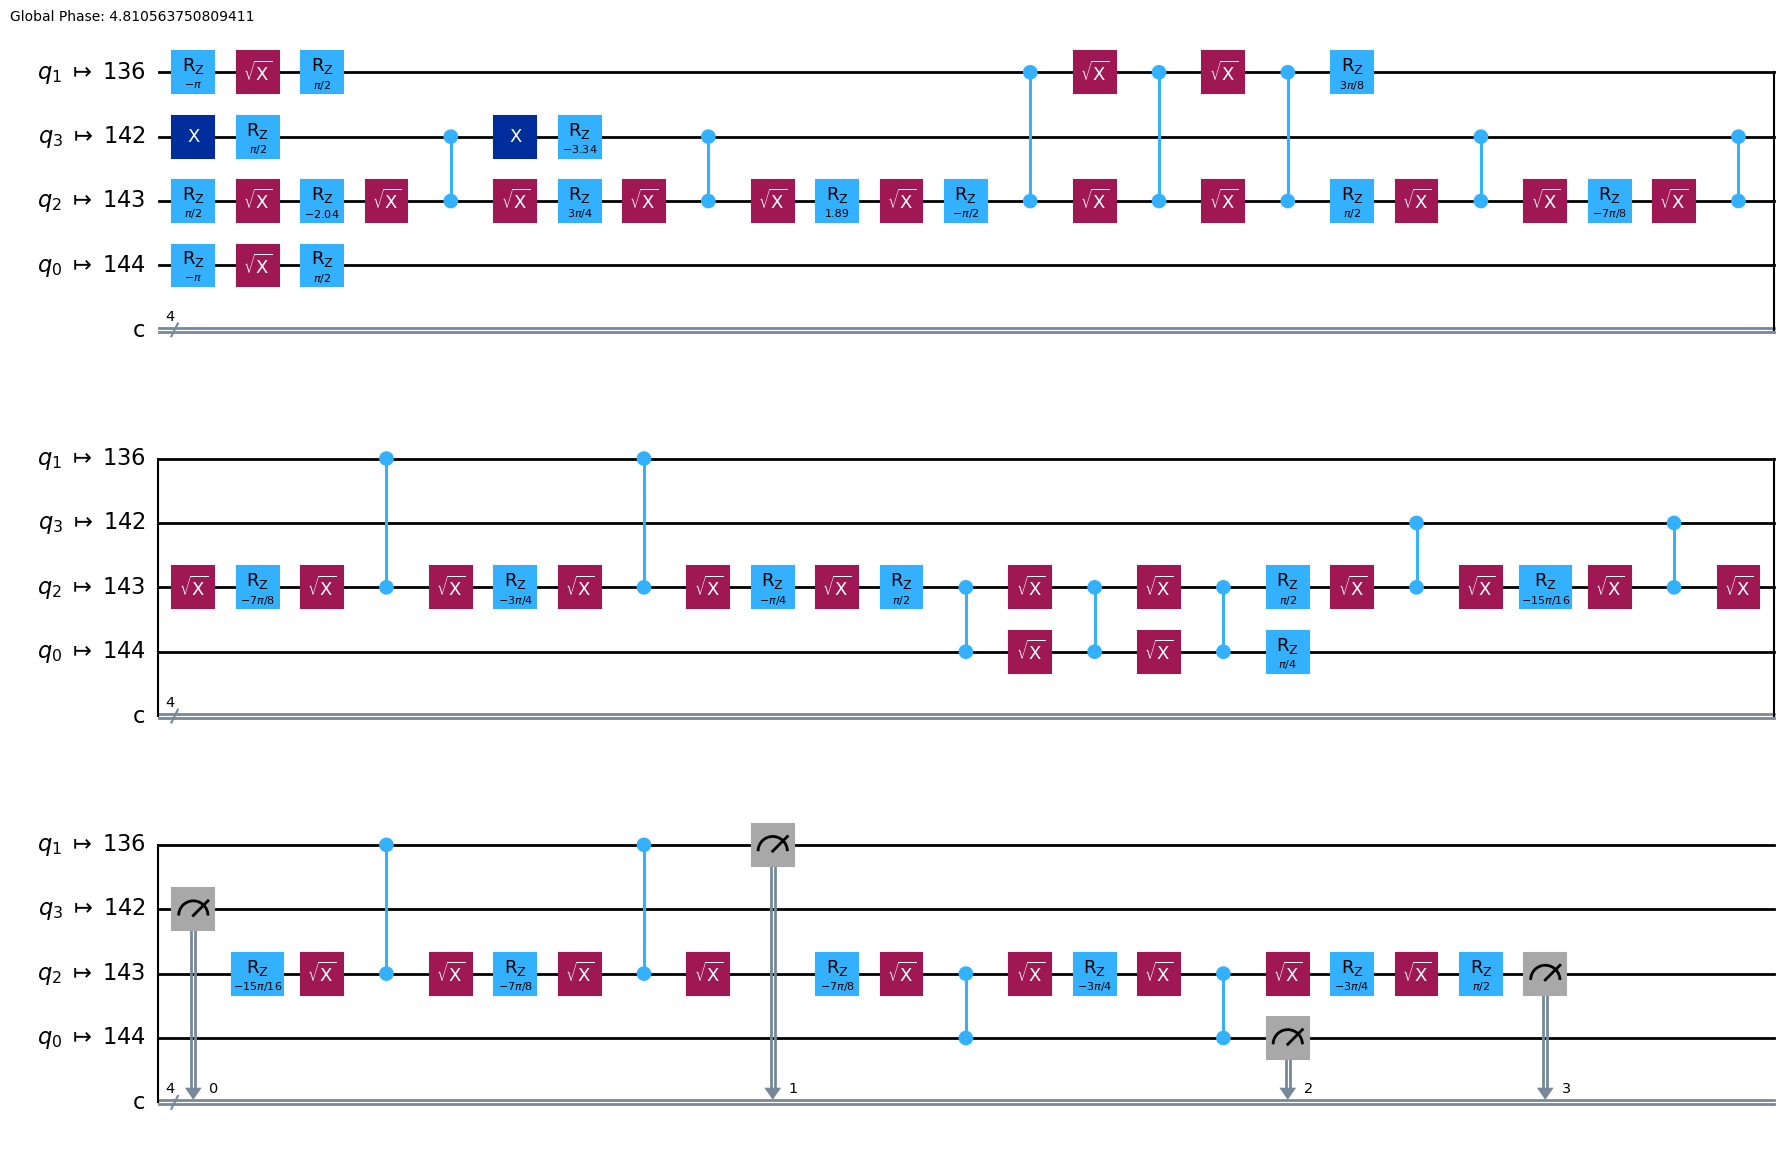

In [8]:

def optimize_circuit(qc: QuantumCircuit, backend=None, optimization_level: int = 3) -> QuantumCircuit:
    """Transpile the circuit for a given backend (or generically if None)."""
    return transpile(qc, backend=backend, optimization_level=optimization_level)

# Example transpile (will target whichever backend is available)
example_qc = create_shors_scaffold(n=15, a=2, num_qubits=8)
qc_transpiled = optimize_circuit(example_qc, backend=ibm_backend or sim_backend, optimization_level=3)
qc_transpiled.draw('mpl')


## Execution helpers (IBM SamplerV2 or local simulator)

In [9]:

def run_ibm_sampler_v2(qc: QuantumCircuit, backend, shots: int = 4096):
    """Run a single circuit on an IBM backend using SamplerV2.
    Returns a counts dict similar to Result.get_counts().
    """
    sampler = SamplerV2(mode=backend)
    job = sampler.run([qc], shots=shots)
    res = job.result()

    # The result schema for SamplerV2 in list form: res[0].data.c.get_counts()
    # We'll try to be defensive in case of version differences.
    try:
        counts = res[0].data.c.get_counts()
        return counts
    except Exception:
        # Fallback attempt: extract quasi-probs then sample to counts
        try:
            quasi = res[0].data.c
            # quasi is usually a dict-like mapping from bitstrings to probabilities
            # We convert to a normalized dict and sample
            keys = list(quasi.keys())
            probs = np.array([float(quasi[k]) for k in keys], dtype=float)
            probs = probs / probs.sum()
            draws = np.random.choice(len(keys), size=shots, p=probs)
            counts = {}
            for idx in draws:
                bit = keys[idx]
                counts[bit] = counts.get(bit, 0) + 1
            return counts
        except Exception as e:
            print("Unexpected IBM result format:", e)
            return {}


def run_simulator_counts(qc: QuantumCircuit, backend=None, shots: int = 4096):
    """Run on a local simulator.
    Prefers qiskit-aer if available. Otherwise, attempts local Sampler from qiskit.primitives.
    Returns a counts dict.
    """
    if backend is not None:
        # Use AerSimulator if available
        compiled = transpile(qc, backend=backend)
        job = backend.run(compiled, shots=shots)
        result = job.result()
        try:
            return result.get_counts()
        except Exception:
            pass  # fall through to primitives

    # Local primitives fallback: qiskit.primitives.Sampler (returns quasi-probs)
    try:
        from qiskit.primitives import Sampler
        sampler = Sampler()
        result = sampler.run([qc]).result()
        quasi = result.quasi_dists[0]
        # Sample to counts
        keys = list(quasi.keys())
        probs = np.array([float(quasi[k]) for k in keys], dtype=float)
        probs = probs / probs.sum()
        draws = np.random.choice(len(keys), size=shots, p=probs)
        counts = {}
        for idx in draws:
            bit = keys[idx]
            counts[bit] = counts.get(bit, 0) + 1
        return counts
    except Exception as e:
        print("No simulator available:", e)
        return {}


def plot_counts(counts: dict, title: str = "Measurement counts"):
    if not counts:
        print("(no counts to plot)")
        return
    # Sort by integer value of bitstring for readability
    items = sorted(counts.items(), key=lambda kv: int(kv[0], 2))
    labels, values = zip(*items)

    # Single-plot bar chart, no custom colors or styles.
    plt.figure()
    plt.bar(range(len(labels)), values)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.title(title)
    plt.xlabel("bitstring (phase register)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.show()


## Classical Post-Processing (factor extraction sketch)

In [10]:

def extract_factors_from_counts(counts: dict, n: int, a: int, verbose: bool = True):
    """Mimic your factor-extraction loop.
    Notes:
    - In a working Shor run, bitstrings correspond to **estimates of fractions** k/r,
      so you'd typically convert to a fraction (via continued fractions) to get a candidate r.
    - Here, we keep your original structure: iterate bitstrings by frequency and try r/2 heuristics.

    Returns a sorted list of unique non-trivial factors found.
    """
    found_factors = set()
    if not counts:
        return []

    for measured_phase_str in sorted(counts, key=lambda k: counts[k], reverse=True):
        phase = int(measured_phase_str, 2)
        if phase == 0:
            continue

        # Heuristic attempt (mirroring your code): try even phases
        if phase % 2 == 0:
            r_half = phase // 2
            val_mod_N = pow(a, r_half, n)

            if val_mod_N != 1 and val_mod_N != (n - 1):
                f1 = math.gcd(pow(a, r_half) - 1, n)
                f2 = math.gcd(pow(a, r_half) + 1, n)

                if f1 not in (1, n):
                    found_factors.add(f1)
                if f2 not in (1, n):
                    found_factors.add(f2)

                if len(found_factors) >= 2 and (1 not in found_factors and n not in found_factors):
                    break

    out = sorted(found_factors)
    if verbose:
        if out:
            print(f"Candidate non-trivial factor(s) for N={n}: {out}")
        else:
            print("No non-trivial factors found with this heuristic (expected with the scaffold circuit)." )
    return out


## Unified Helper: Build → Transpile → Run → Extract

In [11]:

def factor_shor_scaffold(n: int, a: int = 2, num_qubits: int = 8, shots: int = 4096,
                         ibm_backend=None, sim_backend=None, plot=True):
    """End-to-end: create scaffold, transpile, run (IBM or simulator), and try to extract factors.
    Returns (counts, factors).
    """
    qc = create_shors_scaffold(n, a, num_qubits)
    target_backend = ibm_backend or sim_backend
    qc_t = optimize_circuit(qc, backend=target_backend, optimization_level=3)

    if ibm_backend is not None:
        try:
            counts = run_ibm_sampler_v2(qc_t, ibm_backend, shots=shots)
        except Exception as e:
            print("IBM run failed, falling back to simulator if available:", e)
            counts = run_simulator_counts(qc_t, backend=sim_backend, shots=shots)
    elif sim_backend is not None:
        counts = run_simulator_counts(qc_t, backend=sim_backend, shots=shots)
    else:
        print("No runnable backend available.")
        return {}, []

    if plot:
        plot_counts(counts, title=f"Counts (n={n}, a={a}, num_qubits={num_qubits})")

    factors = extract_factors_from_counts(counts, n=n, a=a, verbose=True)
    return counts, factors, qc_t


## Example Run

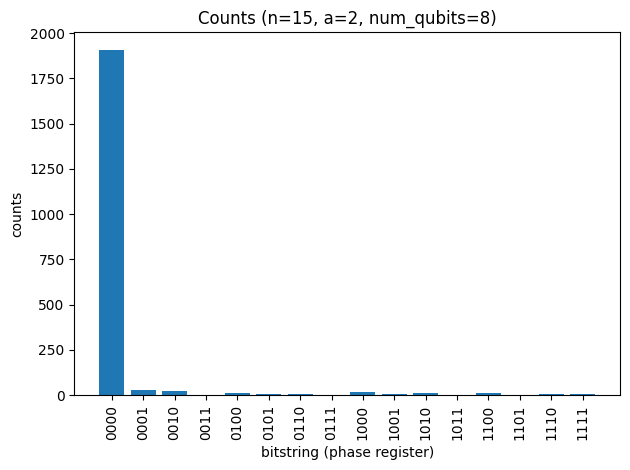

Candidate non-trivial factor(s) for N=15: [3, 5]

Counts (top 10): {'0000': 1909, '0001': 29, '0010': 22, '1000': 18, '0100': 13, '1100': 11, '1010': 11, '1111': 8, '1110': 7, '0110': 5}
Candidate factors: [3, 5]


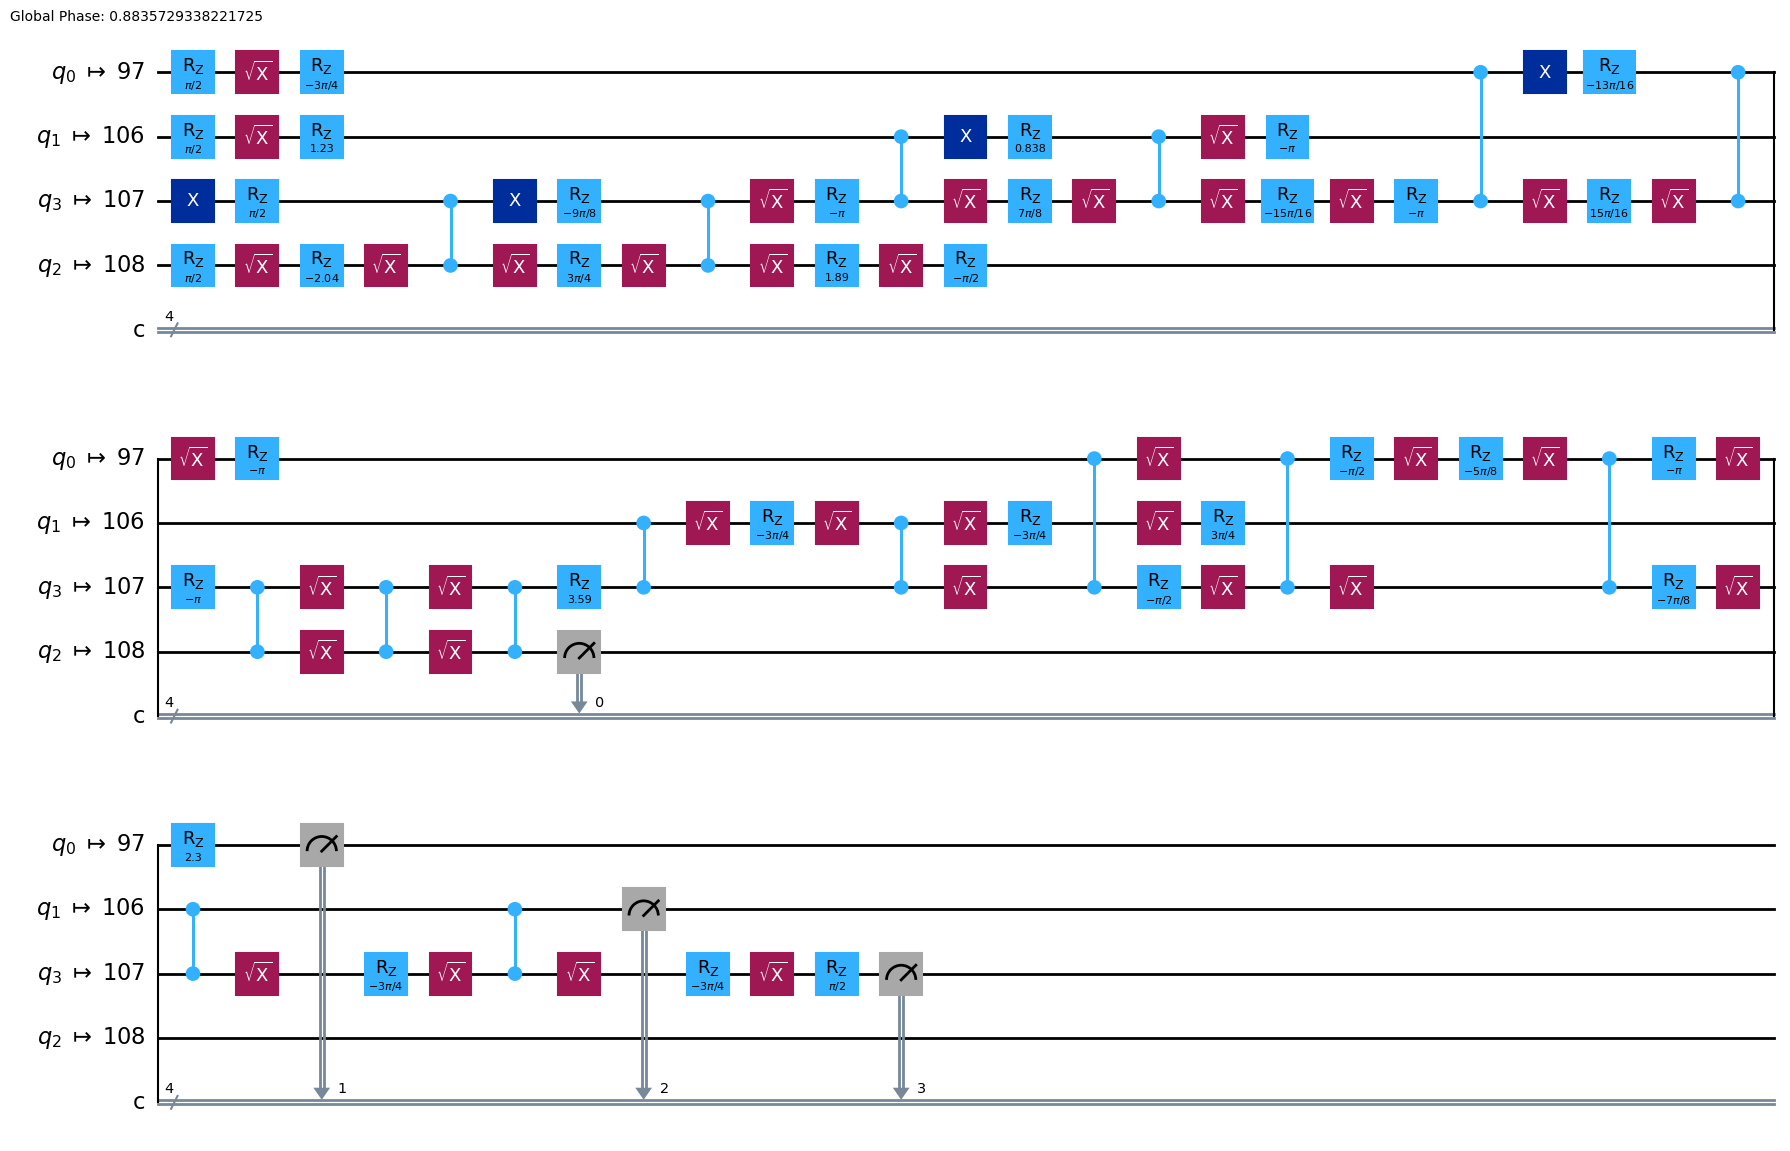

In [ ]:

# Example parameters
n = 15        # composite to factor (3 * 5)
a = 2         # base
num_qubits = 2 * math.ceil(math.log2(n))
shots = 2048

counts, factors, qc_t = factor_shor_scaffold(
    n=n, a=a, num_qubits=num_qubits, shots=shots,
    ibm_backend=ibm_backend, sim_backend=sim_backend, plot=True
)

print("\nCounts (top 10):", dict(list(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))[:10]))
print("Candidate factors:", factors)
qc_t.draw(output='mpl')

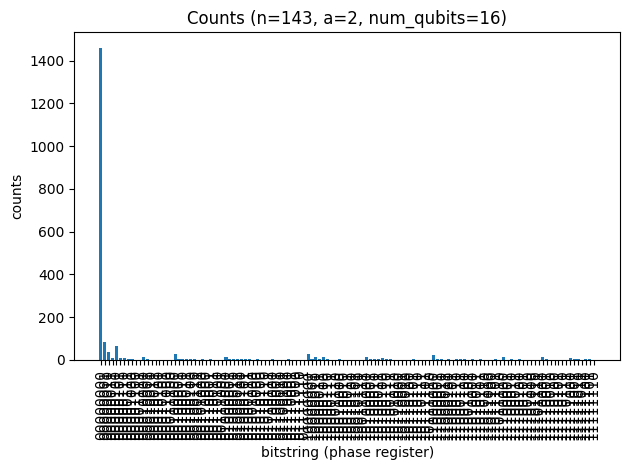

Candidate non-trivial factor(s) for N=143: [11, 13]

Counts (top 10): {'00000000': 1460, '00000001': 83, '00000100': 65, '00000010': 36, '10000000': 28, '00100000': 26, '11000000': 21, '10100000': 14, '01000000': 13, '10000010': 13}
Candidate factors: [11, 13]


In [ ]:
n = 143        # composite to factor (13 * 11)
a = 2         # base
num_qubits = 2 * math.ceil(math.log2(n))
shots = 2048

counts, factors, qc_t = factor_shor_scaffold(
    n=n, a=a, num_qubits=num_qubits, shots=shots,
    ibm_backend=ibm_backend, sim_backend=sim_backend, plot=True
)

print("\nCounts (top 10):", dict(list(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))[:10]))
print("Candidate factors:", factors)


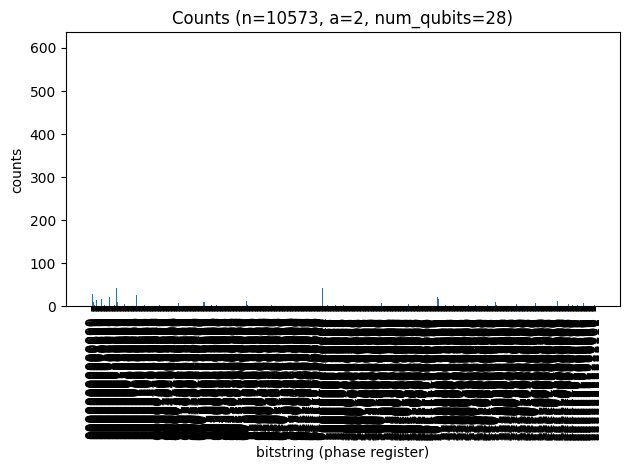

Candidate non-trivial factor(s) for N=10573: [97, 109]

Counts (top 10): {'00000000000000': 606, '00000000000001': 163, '00000001000000': 44, '10000000000000': 43, '00000000000010': 30, '00000100000000': 27, '00000000100000': 22, '11000000000000': 21, '10000000000001': 19, '11000000000001': 17}
Candidate factors: [97, 109]


In [14]:
n = 10573        # composite to factor (97 * 109); 
a = 2        
num_qubits = 2 * math.ceil(math.log2(n))
shots = 2048

counts, factors, qc_t = factor_shor_scaffold(
    n=n, a=a, num_qubits=num_qubits, shots=shots,
    ibm_backend=ibm_backend, sim_backend=sim_backend, plot=True
)

print("\nCounts (top 10):", dict(list(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))[:10]))
print("Candidate factors:", factors)


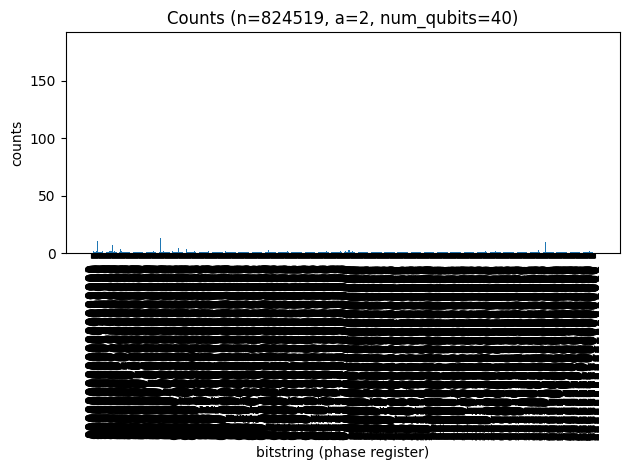

Candidate non-trivial factor(s) for N=824519: [827, 997]

Counts (top 10): {'00000000000000000000': 183, '00000000001000000000': 32, '00000000000100000000': 30, '00000000100000000000': 24, '00000010000000000000': 16, '00000001000000000000': 16, '00000000000010000000': 13, '00000100000000000000': 13, '00000000000001000000': 11, '00000000000000001000': 10}
Candidate factors: [827, 997]


In [15]:
n = 824519        # composite to factor (827 * 997)
a = 2         
num_qubits = 2 * math.ceil(math.log2(n))
shots = 2048

counts, factors, qc_t = factor_shor_scaffold(
    n=n, a=a, num_qubits=num_qubits, shots=shots,
    ibm_backend=ibm_backend, sim_backend=sim_backend, plot=True
)

print("\nCounts (top 10):", dict(list(sorted(counts.items(), key=lambda kv: kv[1], reverse=True))[:10]))
print("Candidate factors:", factors)


In [16]:
qc_t.depth()

966